# DeepLearning SummerSemester 2025 - Assignment 4
Estelle Klevenz

01/923235

In [1]:
import subprocess
import sys
import pandas as pd
import random
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, TaskType
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

2025-07-14 20:35:24.219761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752525324.242837     235 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752525324.250066     235 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Model Training

In [2]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Qwen Model

# Model configuration
model_name = "Qwen/Qwen3-0.6B"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f" Loading Qwen 3 model: {model_name}")
print(f" Device: {device}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Load Qwen 3 model (full precision)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto" if torch.cuda.is_available() else None,
)

print(" Qwen 3 model and tokenizer loaded successfully!")
print(f" Model parameters: {model.num_parameters():,}")

 Loading Qwen 3 model: Qwen/Qwen3-0.6B
 Device: cuda
 Qwen 3 model and tokenizer loaded successfully!
 Model parameters: 596,049,920


In [4]:
def calculate_exact_match_accuracy(predictions, true_labels):
    matches = sum(pred.strip().lower() == true.strip().lower() for pred, true in zip(predictions, true_labels))
    return matches / len(predictions)

def calculate_partial_match_accuracy(predictions, true_labels):
    matches = 0
    for pred, true in zip(predictions, true_labels):
        pred_codes = set(code.strip() for code in pred.split(',') if code.strip())
        true_codes = set(code.strip() for code in true.split(',') if code.strip())
        if pred_codes & true_codes:
            matches += 1
    return matches / len(predictions)

def calculate_precision_recall(predictions, true_labels):
    total_precision = total_recall = valid_samples = 0
    for pred, true in zip(predictions, true_labels):
        pred_codes = set(code.strip() for code in pred.split(',') if code.strip())
        true_codes = set(code.strip() for code in true.split(',') if code.strip())
        if pred_codes and true_codes:
            intersection = pred_codes & true_codes
            total_precision += len(intersection) / len(pred_codes)
            total_recall += len(intersection) / len(true_codes)
            valid_samples += 1
    if valid_samples == 0:
        return 0, 0, 0
    avg_precision = total_precision / valid_samples
    avg_recall = total_recall / valid_samples
    f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    return avg_precision, avg_recall, f1

In [5]:
from datasets import Dataset

### Task A

In [6]:
#import shutil

# Copy dataset directory from read-only input to writable working directory
#shutil.copytree("/kaggle/input/austrian-parliament/party_classification_ds", 
                "/kaggle/working/party_classification_ds")


FileExistsError: [Errno 17] File exists: '/kaggle/working/party_classification_ds'

In [7]:
from datasets import load_from_disk

party_classification = load_from_disk("/kaggle/working/party_classification_ds")

In [8]:
party_classification

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 16406
})

In [9]:
split1 = party_classification.train_test_split(test_size=0.3, seed=42)
party_train_ds = split1["train"]
party_eval_ds = split1["test"]

split2 = party_eval_ds.train_test_split(test_size=0.5, seed=42)
party_valid_ds = split2["train"]
party_test_ds = split2["test"]

print(f"Training samples: {len(party_train_ds)}")
print(f"Validation samples: {len(party_valid_ds)}")
print(f"Validation samples: {len(party_test_ds)}")

Training samples: 11484
Validation samples: 2461
Validation samples: 2461


In [10]:
party_train_df = pd.DataFrame(party_train_ds)

In [11]:
party_train_df['label'].value_counts() 

label
ÖVP      3396
SPÖ      2745
FPÖ      2230
NEOS     1395
GRÜNE    1343
JETZT     375
Name: count, dtype: int64

In [12]:
# baseline evaluation

def generate_prediction(text, model, tokenizer):
    """Generate IPC code prediction using the base Qwen 3 model with chat template"""
    # Create messages in the format expected by Qwen 3
    messages = [
        {
            "role": "user",
            "content": f"You are an expert of the Autrian parties and parliament. Match this speech to the parliamentary party it comes from. Provide only the austrian party's acronym. Nothing else. \n\nSpeech: {text[:500]}..."
        }
    ]

    # Apply chat template with thinking disabled for consistency
    formatted_text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False  # Disable for consistency with training
    )

    model_inputs = tokenizer([formatted_text], return_tensors="pt", max_length=4000, truncation=True).to(model.device)


    # Generate prediction with proper stopping
    with torch.inference_mode():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=50,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,  # Ensure EOS token stops generation
        )

    # Extract only the new tokens
    output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

    # Decode the response and remove EOS token if present
    content = tokenizer.decode(output_ids, skip_special_tokens=True).strip()

    return content

In [13]:
def evaluate_model_predictions(model, model_name, eval_dataset, tokenizer, num_samples=None):
    """Evaluate model predictions on test set"""

    # Use all samples for evaluation since we have a small dataset
    if num_samples is None:
        num_samples = len(eval_dataset)

    predictions = []
    true_labels = []

    print(f"\n Evaluating {model_name} on {num_samples} samples...")

    for i in range(min(num_samples, len(eval_dataset))):
        sample = eval_dataset[i]


        prediction = generate_prediction(sample['text'], model, tokenizer)

        predictions.append(prediction)
        true_labels.append(sample['label'])

        # Show progress
        if (i + 1) % 10 == 0:
            print(f"   Processed {i + 1}/{num_samples} samples...")

        if i < 3:  # Show first few examples
            print(f"   Example {i+1}:")
            print(f"      True: {sample['label']}")
            print(f"      Pred: {prediction}")

    return predictions, true_labels

In [14]:
# Test baseline model on a few samples
for i in range(3):
    sample = party_valid_ds[i]
    prediction = generate_prediction(sample["text"], model, tokenizer)
    print(f"\n Sample {i+1}:")
    print(f"   True IPC: {sample['label']}")
    print(f"   Predicted: {prediction}")

# Evaluate both models
results1 = {}

# Base model evaluation
print("Evaluating Base Qwen 3 Model...")
base_preds, true_labels = evaluate_model_predictions(
    model, "Base Qwen 3", party_test_ds, tokenizer
)
results1["Base Qwen 3"] = base_preds


 Sample 1:
   True IPC: SPÖ
   Predicted: AUT

 Sample 2:
   True IPC: NEOS
   Predicted: AUT

 Sample 3:
   True IPC: FPÖ
   Predicted: SPÖ
Evaluating Base Qwen 3 Model...

 Evaluating Base Qwen 3 on 2461 samples...
   Example 1:
      True: GRÜNE
      Pred: AUST
   Example 2:
      True: JETZT
      Pred: AUST
   Example 3:
      True: FPÖ
      Pred: AUSTRIAN PARTY: AUST
   Processed 10/2461 samples...
   Processed 20/2461 samples...
   Processed 30/2461 samples...
   Processed 40/2461 samples...
   Processed 50/2461 samples...
   Processed 60/2461 samples...
   Processed 70/2461 samples...
   Processed 80/2461 samples...
   Processed 90/2461 samples...
   Processed 100/2461 samples...
   Processed 110/2461 samples...
   Processed 120/2461 samples...
   Processed 130/2461 samples...
   Processed 140/2461 samples...
   Processed 150/2461 samples...
   Processed 160/2461 samples...
   Processed 170/2461 samples...
   Processed 180/2461 samples...
   Processed 190/2461 samples...
   

In [15]:
from datasets import Dataset
import pandas as pd

def prepare_instruction_dataset(dataset, tokenizer, max_length=512):
    """Prepare dataset for instruction fine-tuning with Qwen chat template format for party prediction"""

    # Convert to DataFrame if needed
    if hasattr(dataset, 'to_pandas'):
        df = dataset.to_pandas()
    else:
        df = pd.DataFrame(dataset)

    formatted_texts = []

    for _, row in df.iterrows():
        messages = [
            {
                "role": "user",
                "content": f"You are an expert of the Autrian parties and parliament. Match this speech to the parliamentary party it comes from. Provide only the acronym of the austrian party. Nothing else.\n\nSpeech: {row['text'][:500]}"
            },
            {
                "role": "assistant",
                "content": row['label'] + tokenizer.eos_token
            }
        ]

        formatted_text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False,
            enable_thinking=False
        )
        formatted_texts.append(formatted_text)

    tokenized_data = tokenizer(
        formatted_texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt",
        return_attention_mask=True,
    )

    labels = tokenized_data["input_ids"].clone()
    labels[tokenized_data["input_ids"] == tokenizer.pad_token_id] = -100

    tokenized_dict = {
        "input_ids": tokenized_data["input_ids"].tolist(),
        "attention_mask": tokenized_data["attention_mask"].tolist(),
        "labels": labels.tolist()
    }

    return Dataset.from_dict(tokenized_dict)


In [16]:
inst_train_ds = prepare_instruction_dataset(party_train_ds, tokenizer)
inst_valid_ds = prepare_instruction_dataset(party_valid_ds, tokenizer)

In [17]:
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, DataCollatorForLanguageModeling

# Configure LoRA for causal language modeling
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=32, #16
    lora_alpha=64, #32
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]#"k_proj"]#, "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Wrap base model with LoRA
inst_model = get_peft_model(model, lora_config)
inst_model.print_trainable_parameters()

# Training arguments
inst_training_args = TrainingArguments(
    output_dir="./instruction_results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    fp16=True,
    logging_steps=10,
    logging_dir=None,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=[],
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    disable_tqdm=False,
    max_grad_norm=1.0,
    dataloader_drop_last=True,
    label_names=["labels"],
)

# Data collator for causal language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8,
    return_tensors="pt",
)


trainable params: 4,587,520 || all params: 600,637,440 || trainable%: 0.7638


In [18]:
from transformers import Trainer

# Create Trainer for instruction fine-tuning
inst_trainer = Trainer(
    model=inst_model,
    args=inst_training_args,
    train_dataset=inst_train_ds,
    eval_dataset=inst_valid_ds,
    data_collator=data_collator,
)

# Start training
training_output = inst_trainer.train()

print(f"Final training loss: {training_output.training_loss:.4f}")

# Save the fine-tuned model and tokenizer
inst_trainer.save_model("./qwen3_party_finetuned_qv")
tokenizer.save_pretrained("./qwen3_party_finetuned_qv")

Step,Training Loss,Validation Loss
50,2.325100,2.262717
100,2.021900,2.042562
150,1.932100,1.947400
200,1.904900,1.893863
250,1.857700,1.865436
300,1.827700,1.847865
350,1.833900,1.838511
400,1.802600,1.830026
450,1.800400,1.820973
500,1.783800,1.812997


Final training loss: 1.9375


('./qwen3_party_finetuned_qv/tokenizer_config.json',
 './qwen3_party_finetuned_qv/special_tokens_map.json',
 './qwen3_party_finetuned_qv/chat_template.jinja',
 './qwen3_party_finetuned_qv/vocab.json',
 './qwen3_party_finetuned_qv/merges.txt',
 './qwen3_party_finetuned_qv/added_tokens.json',
 './qwen3_party_finetuned_qv/tokenizer.json')

In [19]:
# Free training memory
#del inst_trainer
#del inst_train_ds, inst_valid_ds
#del training_output
torch.cuda.empty_cache()
import gc
gc.collect()

print("Training memory freed. Only base and fine-tuned models remain.")

Training memory freed. Only base and fine-tuned models remain.


In [20]:
!zip -r qwen3_party_finetuned_qv.zip qwen3_party_finetuned_qv/

  adding: qwen3_party_finetuned_qv/ (stored 0%)
  adding: qwen3_party_finetuned_qv/README.md (deflated 66%)
  adding: qwen3_party_finetuned_qv/special_tokens_map.json (deflated 69%)
  adding: qwen3_party_finetuned_qv/chat_template.jinja (deflated 76%)
  adding: qwen3_party_finetuned_qv/added_tokens.json (deflated 68%)
  adding: qwen3_party_finetuned_qv/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 81%)
  adding: qwen3_party_finetuned_qv/adapter_model.safetensors (deflated 7%)
  adding: qwen3_party_finetuned_qv/tokenizer_config.json (deflated 90%)
  adding: qwen3_party_finetuned_qv/merges.txt (deflated 57%)
  adding: qwen3_party_finetuned_qv/vocab.json (deflated 61%)
  adding: qwen3_party_finetuned_qv/training_args.bin (deflated 52%)
  adding: qwen3_party_finetuned_qv/adapter_config.json (deflated 55%)


In [21]:
from sklearn.metrics import balanced_accuracy_score
# Evaluate fine-tuned model
finetuned_preds1, _ = evaluate_model_predictions(model, "Fine-tuned Qwen 3", party_test_ds, tokenizer)
results1["Fine-tuned Qwen 3"] = finetuned_preds1

metrics_summary1 = {}
for model_name, preds in results1.items():
    exact_acc = calculate_exact_match_accuracy(preds, true_labels)
    partial_acc = calculate_partial_match_accuracy(preds, true_labels)
    balanced_acc = balanced_accuracy_score(preds, true_labels)
    precision, recall, f1 = calculate_precision_recall(preds, true_labels)
    metrics_summary1[model_name] = {
        'exact_acc': exact_acc,
        'partial_acc': partial_acc,
        'balanced_acc': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


 Evaluating Fine-tuned Qwen 3 on 2461 samples...
   Example 1:
      True: GRÜNE
      Pred: ÖVP
   Example 2:
      True: JETZT
      Pred: GRÜNE
   Example 3:
      True: FPÖ
      Pred: ÖVP
   Processed 10/2461 samples...
   Processed 20/2461 samples...
   Processed 30/2461 samples...
   Processed 40/2461 samples...
   Processed 50/2461 samples...
   Processed 60/2461 samples...
   Processed 70/2461 samples...
   Processed 80/2461 samples...
   Processed 90/2461 samples...
   Processed 100/2461 samples...
   Processed 110/2461 samples...
   Processed 120/2461 samples...
   Processed 130/2461 samples...
   Processed 140/2461 samples...
   Processed 150/2461 samples...
   Processed 160/2461 samples...
   Processed 170/2461 samples...
   Processed 180/2461 samples...
   Processed 190/2461 samples...
   Processed 200/2461 samples...
   Processed 210/2461 samples...
   Processed 220/2461 samples...
   Processed 230/2461 samples...
   Processed 240/2461 samples...
   Processed 250/2461 s

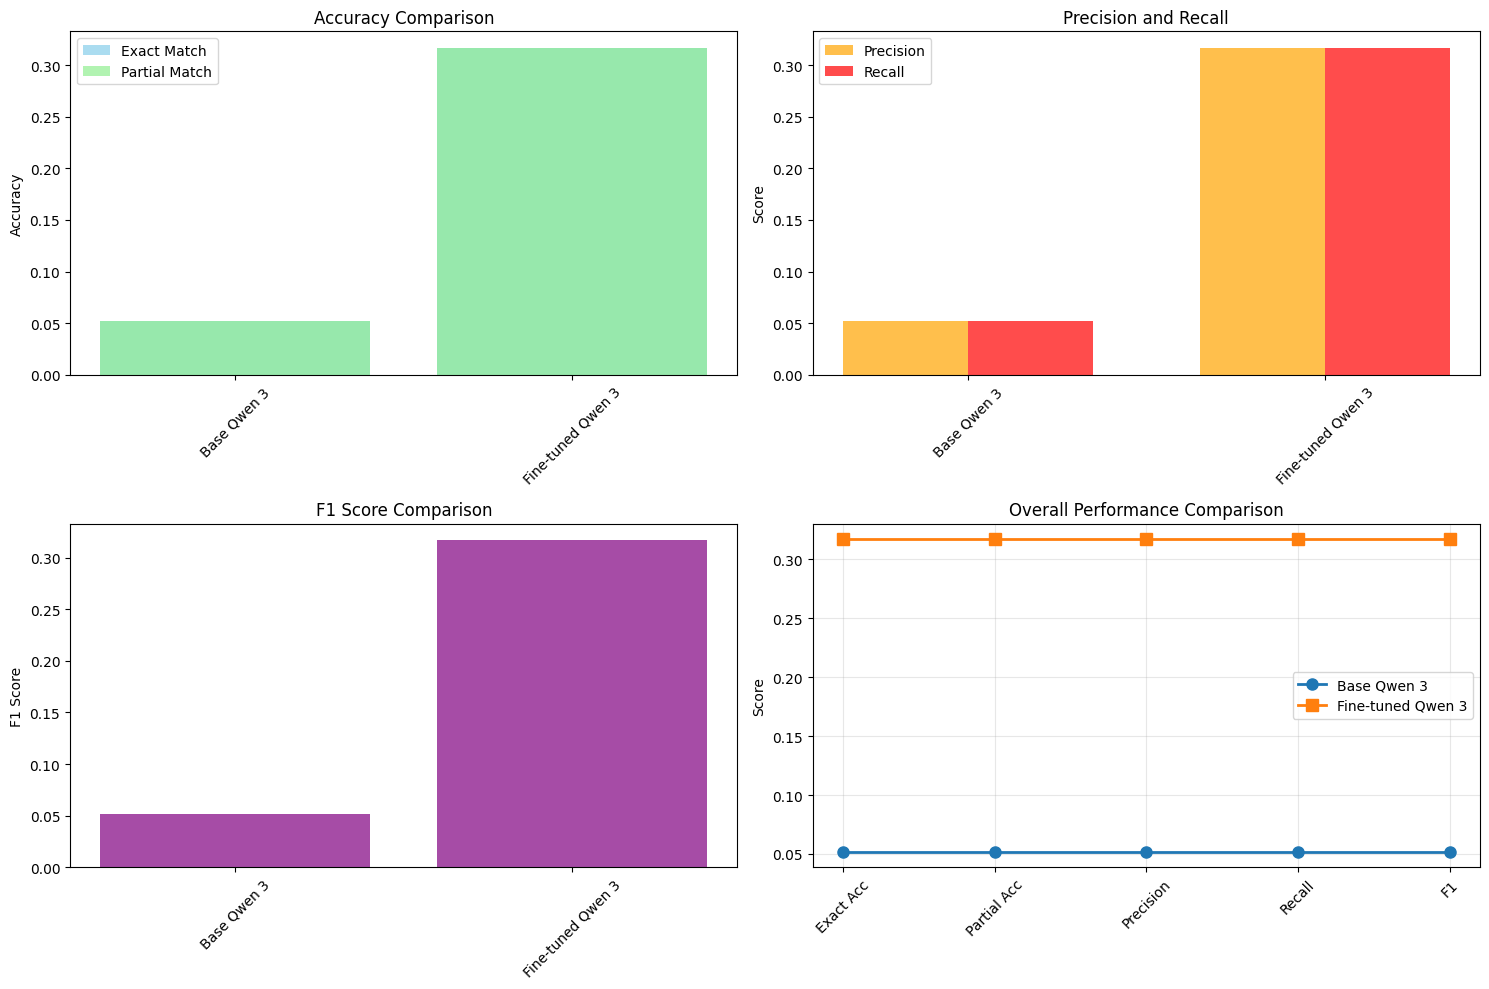

In [22]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
model_names = list(results1.keys())
exact_accuracies = [metrics_summary1[name]['exact_acc'] for name in model_names]
partial_accuracies = [metrics_summary1[name]['partial_acc'] for name in model_names]
precisions = [metrics_summary1[name]['precision'] for name in model_names]
recalls = [metrics_summary1[name]['recall'] for name in model_names]
f1_scores = [metrics_summary1[name]['f1'] for name in model_names]

axes[0, 0].bar(model_names, exact_accuracies, alpha=0.7, label='Exact Match', color='skyblue')
axes[0, 0].bar(model_names, partial_accuracies, alpha=0.7, label='Partial Match', color='lightgreen')
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

x = np.arange(len(model_names))
width = 0.35
axes[0, 1].bar(x - width/2, precisions, width, label='Precision', alpha=0.7, color='orange')
axes[0, 1].bar(x + width/2, recalls, width, label='Recall', alpha=0.7, color='red')
axes[0, 1].set_title('Precision and Recall')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names, rotation=45)
axes[0, 1].legend()

axes[1, 0].bar(model_names, f1_scores, alpha=0.7, color='purple')
axes[1, 0].set_title('F1 Score Comparison')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].tick_params(axis='x', rotation=45)

metrics = ['Exact Acc', 'Partial Acc', 'Precision', 'Recall', 'F1']
base_scores = [exact_accuracies[0], partial_accuracies[0], precisions[0], recalls[0], f1_scores[0]]
ft_scores = [exact_accuracies[1], partial_accuracies[1], precisions[1], recalls[1], f1_scores[1]]

axes[1, 1].plot(metrics, base_scores, 'o-', label=model_names[0], linewidth=2, markersize=8)
axes[1, 1].plot(metrics, ft_scores, 's-', label=model_names[1], linewidth=2, markersize=8)
axes[1, 1].set_title('Overall Performance Comparison')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("evaluation_party_qv.png")
plt.show()

In [23]:
!zip -r instruction_results_party.zip instruction_results/

updating: instruction_results/ (stored 0%)
updating: instruction_results/checkpoint-600/ (stored 0%)
updating: instruction_results/checkpoint-600/README.md (deflated 66%)
updating: instruction_results/checkpoint-600/scaler.pt (deflated 60%)
updating: instruction_results/checkpoint-600/trainer_state.json (deflated 78%)
updating: instruction_results/checkpoint-600/rng_state.pth (deflated 25%)
updating: instruction_results/checkpoint-600/special_tokens_map.json (deflated 69%)
updating: instruction_results/checkpoint-600/chat_template.jinja (deflated 76%)
updating: instruction_results/checkpoint-600/scheduler.pt (deflated 55%)
updating: instruction_results/checkpoint-600/added_tokens.json (deflated 68%)
updating: instruction_results/checkpoint-600/tokenizer.json

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 81%)
updating: instruction_results/checkpoint-600/adapter_model.safetensors (deflated 7%)
updating: instruction_results/checkpoint-600/tokenizer_config.json (deflated 90%)
updating: instruction_results/checkpoint-600/optimizer.pt (deflated 8%)
updating: instruction_results/checkpoint-600/merges.txt (deflated 57%)
updating: instruction_results/checkpoint-600/vocab.json (deflated 61%)
updating: instruction_results/checkpoint-600/training_args.bin (deflated 52%)
updating: instruction_results/checkpoint-600/adapter_config.json (deflated 55%)
updating: instruction_results/checkpoint-718/ (stored 0%)
updating: instruction_results/checkpoint-718/README.md (deflated 66%)
updating: instruction_results/checkpoint-718/scaler.pt (deflated 60%)
updating: instruction_results/checkpoint-718/trainer_state.json (deflated 79%)
updating: instruction_results/checkpoint-718/rng_state.pth (deflated 25%)
updating: instruction_results/checkpoint-718/special_tokens_map.json (deflated 69%)
updating: 

In [24]:
df_results_1 = pd.DataFrame(results1)

In [25]:
df_results_1['true_label'] = party_test_ds['label']

In [26]:
df_results_1.to_csv('party_results_qv.csv', index=False)

In [27]:
df_results_1

,Base Qwen 3,Fine-tuned Qwen 3,true_label
0,AUST,ÖVP,GRÜNE
1,AUST,GRÜNE,JETZT
2,AUSTRIAN PARTY: AUST,ÖVP,FPÖ
3,SPÖ,ÖVP,NEOS
4,AUSTRIAN PARTY: AUST,GRÜNE,FPÖ
...,...,...,...
2456,AUSTRIAN PARTY: AUST,GRÜNE,SPÖ
2457,AUSTRIAN PARTY: AUST,ÖVP,FPÖ
2458,AUSTRIAN PARTY: AUST,ÖVP,FPÖ
2459,AUSTRIAN PARTY: AUST,ÖVP,SPÖ


In [28]:
df_metrics_summary1 = pd.DataFrame(metrics_summary1)

In [29]:
df_metrics_summary1.to_csv('party_metrics_qv.csv', index=False)

In [30]:
balanced_accuracy1 = balanced_accuracy_score(party_test_ds['label'],results1['Fine-tuned Qwen 3'])
print("Balanced Accuracy:", balanced_accuracy1)
print("Classification Report:\n", classification_report(party_test_ds['label'],results1['Fine-tuned Qwen 3'], digits=4))

Balanced Accuracy: 0.27063917631143086
Classification Report:
               precision    recall  f1-score   support

         FPÖ     0.7215    0.1090    0.1894       523
          GR     0.0000    0.0000    0.0000         0
       GRÜNE     0.1498    0.5113    0.2317       266
       JETZT     0.7500    0.0405    0.0769        74
        NEOS     0.7467    0.1739    0.2821       322
         SPÖ     0.4607    0.2287    0.3057       564
         ÖVP     0.3582    0.5604    0.4370       712

    accuracy                         0.3169      2461
   macro avg     0.4553    0.2320    0.2175      2461
weighted avg     0.4990    0.3169    0.3010      2461



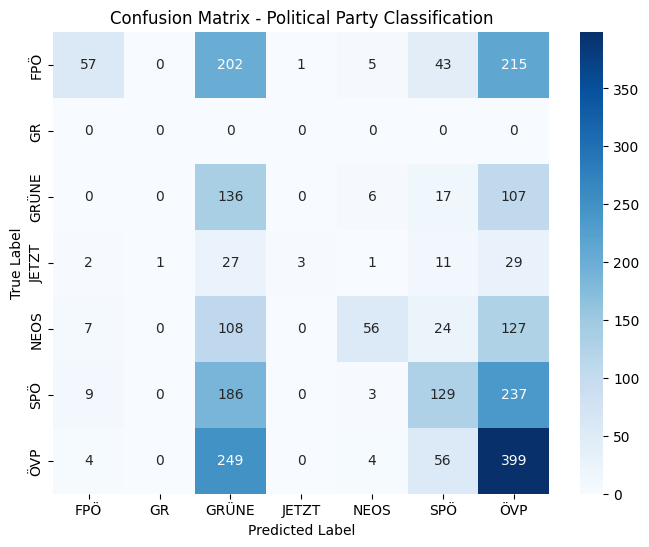

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Get sorted unique labels from true and predicted labels
labels = sorted(set(party_test_ds['label']) | set(results1['Fine-tuned Qwen 3']))

# Compute confusion matrix with fixed label order
conf_matrix = confusion_matrix(
    party_test_ds['label'], 
    results1['Fine-tuned Qwen 3'], 
    labels=labels
)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Political Party Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('./party-confusion_qv')
plt.show()


### Task B